<center><img src="header.png" width = "800"/></center>

### <b> InSAR Coherent Change Detection over Aleppo, Syria (April 17-29, 2016)
    
<b><i> Corey Scher<sup>1</sup>
<i>Jamon Van Den Hoek<sup>2</sup>
    
<i><font size=2> 1. Department of Earth and Environmental Sciences | Graduate Center at the City University of New York
    
<i><font size=2> 2. College of Earth, Ocean, and Atmospheric Sciences | Oregon State University

<span style="font-size: 16pt"> **Part one**: query and task the ASF Vertex platform using the [HyP3 Python SDK](https://hyp3-docs.asf.alaska.edu/using/sdk_api/) </span>

### Introduction

   In this training we will walk through an example of bi-temporal coherent change detection over Aleppo, Syria to map proxies for urban damage that occurred as a result of air bombardments over a two week period in April 2016. We will be using the [Alaska Satellite Facility's](https://asf.alaska.edu/) [Vertex tool](https://search.asf.alaska.edu/#/) to generate two synthetic aperture radar [interferogram](https://appliedsciences.nasa.gov/sites/default/files/Session4-SAR-English_0.pdf) (InSAR) datasets to look for anomalous decreases in InSAR measurements of [coherence](https://en.wikipedia.org/wiki/Coherence_(physics) that occurred following a series of airstrike bombardments. This workflow can be completed either using the ASF [Hyp3 Python SDK](https://hyp3-docs.asf.alaska.edu/), as we will demonstrate in this notebook, or by generating InSAR coherence images manually using the ASF Vertex [user interface](https://search.asf.alaska.edu/#/) and raster band math in a geographic information system interface, such as [QGIS](https://www.qgis.org/en/site/).

In [42]:
import os
import folium
#import rioxarray
import shapely.wkt
import pandas as pd
import xarray as xr
import geopandas as gpd
import asf_search as asf
from hyp3_sdk import HyP3
import shapely.geometry as shp
import matplotlib.pyplot as plt

In [43]:
# Make our pandas plots interactive
pd.options.plotting.backend = "plotly"

In [5]:
#Define and area of interest as WKT over Aleppo, Syria
aoi = shapely.wkt.loads("POLYGON((37.0072 36.091, \
                        37.3326 36.091,37.3326 36.3183, \
                        37.0072 36.3183,37.0072 36.091))")

# Translate to geojson for quick addition to interactrive Folium maps
geo_j = folium.GeoJson(data=gpd.GeoSeries(aoi).to_json())

In [6]:
# Import credentials from .config file
# The .config file is omitted from GitHub. 
# You can simply skip this step and enter your ASF Vertex username and password directly in the next cell

credentials = pd.read_csv('/Users/coreyscher/Documents/GitHub/arset/hyp3.config', 
                          header = None, 
                          names = ['names', 'values']).set_index('names')

In [7]:
# Authenticate to Hyp3 
hyp3 = HyP3(username=credentials.loc['username'][0], 
            password=credentials.loc['password'][0])

In [8]:
# Let's define a bounding box area with well known text

wkt = "POLYGON((37.0072 36.091,37.3326 36.091,37.3326 36.3183,37.0072 36.3183,37.0072 36.091))"

# Search ASF vertex for Sentinel-1 SLC scenesover the WKT region, 
# Return only 100 results until April 18, 2016
results = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1], 
                         intersectsWith=wkt, 
                         maxResults=10,
                        processingLevel = 'SLC',
                        end = '2016-04-18').data


In [12]:
# Function to translate Sentinel-1 swath footprint text into a shapely polygon and return alongside the fileID

def addFootprint(result):
    props = result.properties
    date = pd.to_datetime(props['startTime'])
    footprint = shp.Polygon(result.geometry['coordinates'][0])
    fid = props['fileID']
    
    return fid, footprint

In [13]:
# Map the function to create a list of footprints and file IDs
# Turn that list into a dataframe for easy indexing

gdf = gpd.GeoDataFrame(list(map(addFootprint, results)), 
                       columns = ['fileID',  'geometry'])


In [44]:
# Create a Folium map centered over Aleppo
mapa = folium.Map([36.207522, 37.154076],
                 #Specify a zoom level
                  zoom_start=7,
                #Specify a basemap
                  tiles='cartodbpositron')

#Add the geo_json of our are of interest to the map
geo_j.add_to(mapa)

# Plot the first five images to choose a reference scene
gdf.iloc[:3].explore(m = mapa, 
            column = 'fileID',
           style_kwds = {'opacity': 1, 'fill': False})

In [26]:
# Let's choose the scene acquired on August 27, 2016 as a reference
reference_scene = gdf.iloc[0]

# Print out the scene ID to make sure it's the right one!
print(reference_scene)

# We can use this ID to generate an InSAR stack with the ASF tools 
insar_stack  = asf.stack_from_id(reference_scene['fileID'])

fileID      S1A_IW_SLC__1SDV_20160417T152456_20160417T1525...
geometry    POLYGON ((39.69199 36.935032, 40.019367 35.314...
Name: 0, dtype: object


In [50]:
# We are going to pick secondary SAR scenes based on temporal baseline
# of about 8 weeks relative to the reference from August 21, 2016.
# Quickly calculate a list of temporal baselines and print
# We will use this list to iterate over our InSAR stack and 
# pick two of the pairs for InSAR processing

temp_baselines = []
for i in insar_stack:
    tempBaseline = i.properties['temporalBaseline']
    days = int(tempBaseline)
    temp_baselines.append([tempBaseline, days, i.properties['fileID']])

temp_baselines = pd.DataFrame(temp_baselines, columns = ['tempBasline', 'days', 'fileID']).set_index('days')



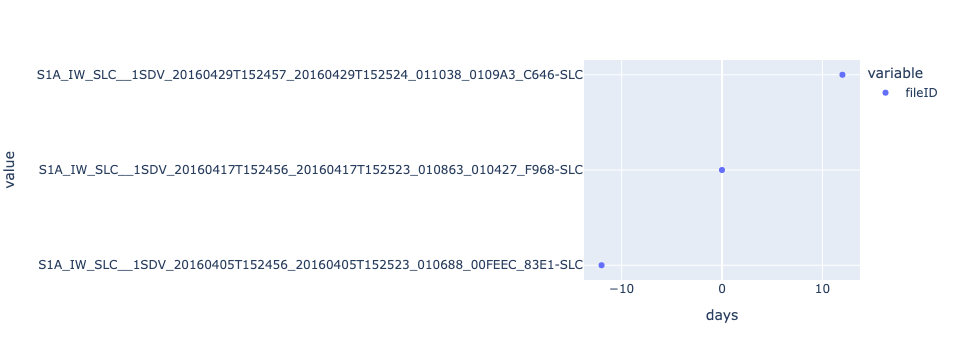

In [55]:
# Let's plot the temporal baseline of the InSAR pairs 12 days before and 12 days after our reference scene acquisition

temp_baselines.loc[-12:12]['fileID'].plot(kind='scatter')

In [56]:
# Let's filter the stack for dates that are of interest for our bi-temporal coherence comparison
picks = []

for i in insar_stack:
    
    # convert the start time of acquisition (string) into a pandas datetime
    start = pd.to_datetime(i.properties['startTime'])
    
    # retrieve the temporal baseline from the search result properties
    tempBaseline = i.properties['temporalBaseline']
    
    # We need a secondary scene representing our "event" period of Sep-Oct, 2016
    # Let's pick an secondary image that was roughly 8 week after our August 21, 2016 reference image
    if 1 < tempBaseline < 13:
        picks.append(i)

    # Now we need an interferogram with a similar temporal baseline to our
    # event period, which is about nine weeks from the reference image.
    if -13 < tempBaseline < -1:
        picks.append(i)

In [69]:
# Make sure these are the right picks by checking fileID and temporal baseline
for i in picks:
    print(i.properties['fileID'], '\n', ' temporal baseline: ', i.properties['temporalBaseline'], ' days',
          '\n', 'perpendicular baseline: ', i.properties['perpendicularBaseline'], ' meters')

S1A_IW_SLC__1SDV_20160405T152456_20160405T152523_010688_00FEEC_83E1-SLC 
  temporal baseline:  -12  days 
 perpendicular baseline:  31  meters
S1A_IW_SLC__1SDV_20160429T152457_20160429T152524_011038_0109A3_C646-SLC 
  temporal baseline:  12  days 
 perpendicular baseline:  10  meters


In [70]:
# Lets plot these on a map and see how they look, making certain we have full coverage over Aleppo

stack = gpd.GeoDataFrame(list(map(addFootprint, picks)), 
                       columns = ['fileID', 'geometry'])

mapb = folium.Map([36.207522, 37.154076],
                zoom_start=7,
                  tiles='cartodbpositron')
#Add the geo_json of our are of interest to the map
geo_j.add_to(mapb)

# Print an interactive map!
stack.explore(m = mapb, column = 'fileID',
           style_kwds = {'opacity': 1, 'fill': False})

In [71]:
#Prepare a list of jobs using the August 21, 2016 scene as a reference
jobs = []
for i in picks:
    
    #We have to remove the "-SLC" string from the fileID for Hyp3 to understand what granules we want!
    jobs.append(hyp3.prepare_insar_job(reference_scene['fileID'].replace('-SLC', ""), 
                       i.properties['fileID'].replace('-SLC', ""), 
                       name='Aleppo', 
    # Specify 10x2 looks in range and in azimuth to create a 40m horizontal resolution coherence image               
                        looks='10x2', 
    # The rest of the settings are default
                       include_look_vectors=False, 
                       include_los_displacement=False, 
                       include_inc_map=False, 
                       include_dem=False, 
                       include_wrapped_phase=False, 
                       apply_water_mask=False, 
                       include_displacement_maps=False))

In [72]:
# Take a look at the list of job dictionaries and make sure they look OK
jobs

[{'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20160417T152456_20160417T152523_010863_010427_F968',
    'S1A_IW_SLC__1SDV_20160405T152456_20160405T152523_010688_00FEEC_83E1'],
   'include_look_vectors': False,
   'include_los_displacement': False,
   'include_inc_map': False,
   'looks': '10x2',
   'include_dem': False,
   'include_wrapped_phase': False,
   'apply_water_mask': False,
   'include_displacement_maps': False},
  'job_type': 'INSAR_GAMMA',
  'name': 'Aleppo'},
 {'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20160417T152456_20160417T152523_010863_010427_F968',
    'S1A_IW_SLC__1SDV_20160429T152457_20160429T152524_011038_0109A3_C646'],
   'include_look_vectors': False,
   'include_los_displacement': False,
   'include_inc_map': False,
   'looks': '10x2',
   'include_dem': False,
   'include_wrapped_phase': False,
   'apply_water_mask': False,
   'include_displacement_maps': False},
  'job_type': 'INSAR_GAMMA',
  'name': 'Aleppo'}]

In [697]:
# These jobs look good so we are going to submit the list and create a batch instance!
batch = hyp3.submit_prepared_jobs(jobs)

In [732]:
# Now we can use the .watch() function to see the status of our batch
hyp3.watch(batch)

100%|██████████████████████████████████████████████████████████████████████| 2/2 [timeout in 10800s]


Batch([Job.from_dict({'job_id': 'c453d7cb-a7b2-4f7a-8956-434da06e4b83', 'job_type': 'INSAR_GAMMA', 'request_time': '2022-05-18T15:46:43+00:00', 'status_code': 'SUCCEEDED', 'user_id': 'coreyscher', 'name': 'Aleppo', 'job_parameters': {'apply_water_mask': False, 'granules': ['S1A_IW_SLC__1SDV_20160821T033420_20160821T033447_012693_013F2C_3748', 'S1A_IW_SLC__1SDV_20160610T033416_20160610T033443_011643_011D02_6360'], 'include_dem': False, 'include_displacement_maps': False, 'include_inc_map': False, 'include_look_vectors': False, 'include_los_displacement': False, 'include_wrapped_phase': False, 'looks': '10x2'}, 'files': [{'filename': 'S1AA_20160610T033416_20160821T033420_VVP072_INT40_G_ueF_3D10.zip', 's3': {'bucket': 'hyp3-contentbucket-fo259f6r6dn6', 'key': 'c453d7cb-a7b2-4f7a-8956-434da06e4b83/S1AA_20160610T033416_20160821T033420_VVP072_INT40_G_ueF_3D10.zip'}, 'size': 354831030, 'url': 'https://hyp3-contentbucket-fo259f6r6dn6.s3.us-west-2.amazonaws.com/c453d7cb-a7b2-4f7a-8956-434da06e4

### Download and unzip InSAR data

In [737]:
insar_path = '/Users/coreyscher/Documents/GitHub/arset/arset/data/insar'

batch.download_files('/Users/coreyscher/Documents/GitHub/arset/arset/data/insar')

  0%|                                                                         | 0/2 [00:00<?, ?it/s]
S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip:   0%| | 0/325262791 [00:00<?, ?it/
S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip:   3%| | 10.0M/310M [00:12<06:11, 8
S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip:   6%| | 20.0M/310M [00:32<08:03, 6
S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip:  10%| | 30.0M/310M [00:40<06:02, 8
S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip:  13%|▏| 40.0M/310M [01:22<11:03, 4
S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip:  16%|▏| 50.0M/310M [01:48<10:49, 4
S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip:  19%|▏| 60.0M/310M [02:20<11:20, 3
S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip:  23%|▏| 70.0M/310M [02:29<08:35, 4
S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip:  26%|▎| 80.0M/310M [02:48

[PosixPath('/Users/coreyscher/Documents/GitHub/arset/arset/data/S1AB_20160821T033420_20161026T033341_VVP066_INT40_G_ueF_C851.zip'),
 PosixPath('/Users/coreyscher/Documents/GitHub/arset/arset/data/S1AA_20160610T033416_20160821T033420_VVP072_INT40_G_ueF_3D10.zip')]